In [9]:
import pde
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import Video


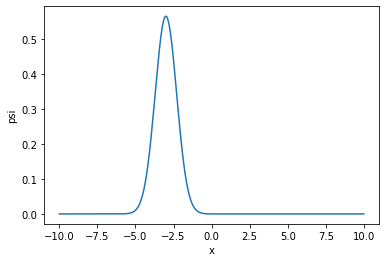

Total Probability:  [1.]


In [2]:
## DEFINE EQUATION TO SIMULATE ##

# Quantum armonic oscillator

w0 = 1                      # omega for harmonic potential
m = 1                       # mass
mu0 = -3                 # center of initial gaussian wave-packet
hbar = 1                   # reduced plank constant

f_name = f'AO_w_{w0}.h5'
path = './Data/Simulations/'
movie_name = f'AO_w_{w0}.mov'
movie_path = './Data/Movie/'

eq = pde.PDE({'psi':f'I*0.5*laplace(psi)/{m} - (0.5*{m}*{w0**2}*x**2)*I*psi'})

## DEFINE SPATIAL GRID ##

Nx = 1000 # number of spatial points
x_left = -10
x_right = 10

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)

dx = grid.discretization
x = grid.cell_coords.flatten()

## DEFINE INITIAL STATE ##

# Create initial wavefunction as coherent state
psi0 = (m*w0/np.pi*hbar)**(1/4)*np.exp(-(0.5*m*w0/hbar)*(x-mu0)**2)
const= 1/np.sqrt(np.sum(np.abs(psi0)**2)*dx) # normalization constant
psi0 = psi0*const

initial_state = pde.ScalarField(grid=grid, data=psi0, label='psi')

initial_state.plot(scalar='norm_squared') # TODO: ADD LABELS 

print("Total Probability: ", np.sum(np.abs(initial_state.data)**2)*dx)


In [3]:
## SOLVE EQUATION ##

# define storage 
storage = pde.MemoryStorage() # for movie
file_storage = pde.FileStorage(filename=path+f_name) # dataset

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = 100
dt_sim = 1e-5

# points to store to file
# N_t_writing = 1000 # can be changed if more points are needed
dt_writing = 0.01

# points to use in animation 
N_t_anim = 1000 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim), file_storage.tracker(interval=dt_writing)])
_ = controller.run(initial_state, dt=dt_sim)



  0%|          | 0/100.0 [00:00<?, ?it/s]

In [4]:
## APPEND X DATA TO CREATED FILE ## 

file = h5py.File(path+f_name, 'a')
file.create_dataset('x', data=x)
file.close()

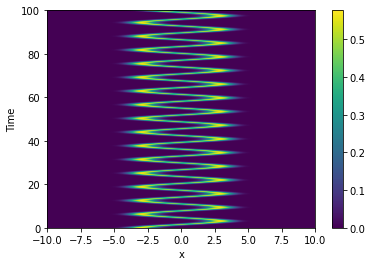

In [5]:
## PLOT SOLUTIONS ##

pde.plot_kymograph(storage, scalar='norm_squared')

In [6]:
from tqdm.notebook import tqdm

def my_pbar(curr_frame, tot_frame):
    pbar.update(100*curr_frame/tot_frame)

In [20]:
## GENERATE MOVIE ##

# set backend to nbagg for better movie quality, not working on deepnote
%matplotlib nbagg

simulation = storage.data
times = storage.times

fig,ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel('a.u.')
title = ax.set_title('', y=1.05)
line1, = ax.plot(x, m*w0*0.5*x**2, "k--", label="V(x)")
line2, = ax.plot(x, np.abs(simulation[0])**2, "b", label=r"$|\psi|^2$")
plt.legend(loc=1, fontsize=8, fancybox=False)
plt.ylim(-0.05, 4)


def init():
    return line1, line2


def animate(i):
    ax.set_facecolor('white')
    line2.set_data(x, np.abs(simulation[i])**2)
    title.set_text('Time = {0:1.3f}'.format(times[i]))
    return line2


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1, blit=True, frames=np.arange(len(times)))

writer = animation.FFMpegWriter(fps=30, bitrate=-1)


print("Generating animation ...")
pbar = tqdm(total=(len(times)-1)*50) # why times 50 works?
anim.save(movie_path+movie_name, writer=writer, dpi=150, progress_callback=my_pbar)
pbar.close()
print("Done")

# reset backend to inline
%matplotlib inline

<IPython.core.display.Javascript object>

Generating animation ...


  0%|          | 0/50000 [00:00<?, ?it/s]

Done


In [21]:
## VISUALIZE MOVIE ## (not working on deepnote)

Video(movie_path+movie_name)

Probability conserved: True


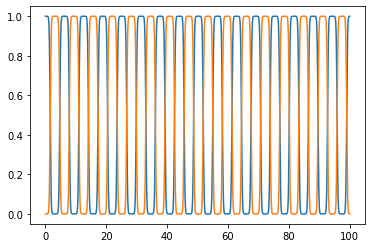

In [23]:
simulation = np.array(simulation)
# compute psi_squared
prob = np.abs(simulation**2)

# compute probability of finding particle on the left or right of the maximum
left_prob = prob[:, x<=0].sum(axis=1)*dx
right_prob = prob[:, x>0].sum(axis=1)*dx

# check if total prob is conserved
print('Probability conserved:', np.allclose(np.ones_like(left_prob), left_prob+right_prob))

plt.plot(times, left_prob)
plt.plot(times, right_prob)

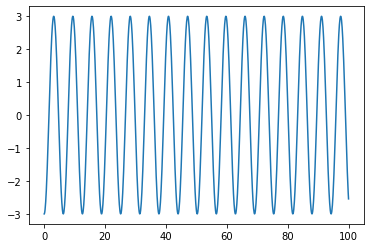

In [24]:
avg_x = np.sum(prob*x, axis=1)*dx
plt.plot(times, avg_x)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>